In [1]:
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline


## imports

In [3]:
import os
from devtools import pprint

In [4]:
from ocrorchestrator.repos.factory import RepoFactory

In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../../secrets/calm-producer-428509-t9-b428a168489d.json"

In [18]:
os.environ["CONFIG_PATH"]="gs://ocrorchestrator/configs/config_v2.yaml"

## testing repo

In [19]:
repo, content = RepoFactory.from_uri(os.environ["CONFIG_PATH"])

In [20]:
content

{'categories': {'proof_of_funds': {'extraction': {'processor': 'LLMProcessor',
    'model': 'gemini-pro-vision',
    'prompt_template': 'general.txt',
    'fields': ['title', 'summary']}},
  'checks': {'validation': {'processor': 'DocumentValidationProcessor',
    'model': 'resnet18__clf.pt',
    'params': [{'img_size': [240, 320], 'target': 'clean'}],
    'classes': ['blanks', 'blurs', 'clean', 'dirty']}}}}

In [8]:
from fastapi import HTTPException

In [9]:
from fastapi.testclient import TestClient


In [10]:
from ocrorchestrator.main import app

In [11]:
client = TestClient(app)

## testing api

### update config

In [12]:
new_config = """
config: 
    categories:
      proof_of_funds:
        validation:
          processor: DocumentValidationProcessor
          model: resnet18__clf.pt
          params: [{img_size: [240, 320], target: clean}]
          classes: ["blanks", "blurs", "clean", "dirty"]
        extraction:
          processor: ApiProcessor
          api: http://localhost:8000/change_config
          params:
            - instances:
              - data: $image
                entity: payee
                guid: $guid
"""

In [13]:
import yaml

In [14]:
new_cfg = yaml.safe_load(new_config)

In [15]:
new_cfg

{'config': {'categories': {'proof_of_funds': {'validation': {'processor': 'DocumentValidationProcessor',
     'model': 'resnet18__clf.pt',
     'params': [{'img_size': [240, 320], 'target': 'clean'}],
     'classes': ['blanks', 'blurs', 'clean', 'dirty']},
    'extraction': {'processor': 'ApiProcessor',
     'api': 'http://localhost:8000/change_config',
     'params': [{'instances': [{'data': '$image',
         'entity': 'payee',
         'guid': '$guid'}]}]}}}}}

In [17]:
with TestClient(app) as client:
    response = client.post("/update_config", json=new_cfg)
    print(response.json())

Reloading 'ocrorchestrator.managers.processor'.
{"event": "**** Starting application ****", "level": "info", "func_name": "lifespan", "lineno": 24, "timestamp": "2024-07-06T17:56:28.829840Z"}
{"event": "**** Initializing processors ****", "level": "info", "func_name": "_initialize", "lineno": 22, "timestamp": "2024-07-06T17:56:28.832719Z"}
{"processor": "DocumentValidationProcessor", "event": "Setting up processor", "level": "info", "func_name": "_initialize", "lineno": 30, "timestamp": "2024-07-06T17:56:28.833241Z"}
{"model_name": "resnet18", "event": "Loading PyTorch classifier", "level": "info", "func_name": "load_model", "lineno": 99, "timestamp": "2024-07-06T17:56:28.833772Z"}
{"event": "Initialized model resnet18 with 4 classes, on cpu", "level": "info", "func_name": "load_pretrained_classifier", "lineno": 31, "timestamp": "2024-07-06T17:56:29.023672Z"}
{"event": "Loading from checkpoint: /home/ajkdrag/workspace/projects/ocrorchestrator/data/my-bucket/models/resnet18__clf.pt", "l

### test vlm

In [12]:
import yaml

In [13]:
from ocrorchestrator.utils.img import base64_to_pil

In [14]:
from base64 import b64encode
from pathlib import Path

b64 = b64encode(Path('../data/images/arch.png').open("rb").read())

In [15]:
req_body = {
    "image": b64.decode(),
    "category": "arch",
    "task": "extraction",
    "guid": "dummyguid",
}

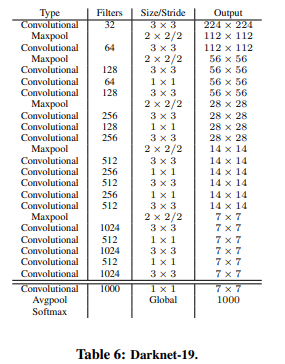

In [16]:
base64_to_pil(b64)

In [17]:
new_config = """
config: 
    categories:
      arch:
        extraction:
          processor: LLMProcessor
          prompt_template: arch_extr.txt
          model: gemini-1.5-flash
          fields: ["layers", "is_arch_convolutional", "num_layers"]
"""

In [18]:
with TestClient(app) as client:
    new_cfg = yaml.safe_load(new_config)
    response = client.post("/update_config", json=new_cfg)
    print(response.json())
    response = client.post("/predict", json=req_body)
    print(response.json())

{"event": "**** Starting application ****", "level": "info", "func_name": "lifespan", "lineno": 23, "timestamp": "2024-07-07T12:31:27.344938Z"}
{"event": "**** Initializing processors ****", "level": "info", "func_name": "_initialize", "lineno": 22, "timestamp": "2024-07-07T12:31:27.347579Z"}
{"processor": "LLMProcessor", "event": "Setting up processor", "level": "info", "func_name": "_initialize", "lineno": 30, "timestamp": "2024-07-07T12:31:27.347963Z"}
{"model_name": "gemini-1.5-flash", "event": "Loading Vertex AI LLM", "level": "info", "func_name": "load_llm", "lineno": 34, "timestamp": "2024-07-07T12:31:27.348713Z"}
{"fields": ["layers", "shapes", "is_arch_convolutional", "num_layers"], "event": "Loading output parser", "level": "info", "func_name": "load_output_parser", "lineno": 45, "timestamp": "2024-07-07T12:31:27.356728Z"}
{"event": "Loading prompt template", "level": "info", "func_name": "load_prompt", "lineno": 52, "timestamp": "2024-07-07T12:31:27.358482Z"}
{"prompt_previe